In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements

In [2]:
# Hooks again but quite different to the previous ones.
# 19 regions each which must add up to 15
# the 2x2 will come into play for the square regions at the bottom
# guess we iterate through the hooks and test if 15 can be made from 
# each potential placement within each region

url='https://www.janestreet.com/puzzles/hooks-7/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:11]))

The grid below can be partitioned into 9 L-shaped “hooks”. The largest is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains 15 squares), and so on. The smallest hook is just a single square. Find where the hooks are located, and place nine 9’s in the largest hook, eight 8’s in the next-largest, etc., down to one 1 in the smallest hook. The filled squares must form a connected region. (Squares are “connected” if they are orthogonally adjacent.) Furthermore, every 2-by-2 region must contain at least one unfilled square. The sum of the values in each of the connected shaded regions must be the same. The answer to this puzzle is the product of the areas of the connected groups of empty squares in the completed grid.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2021/02/20210202_hooks_7.png" width="500" height="300">

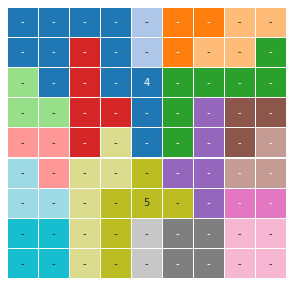

In [35]:
#Setup the constraints

groups = np.array([[0 ,0 ,0 ,0 ,1 ,2 ,2 ,3 ,3 ],
                   [0 ,0 ,6 ,0 ,1 ,2 ,3 ,3 ,4 ],
                   [5 ,0 ,6 ,0 ,0 ,4 ,4 ,4 ,4 ],
                   [5 ,5 ,6 ,6 ,0 ,4 ,8 ,9 ,9 ],
                   [7 ,7 ,6 ,16,0 ,4 ,8 ,9 ,10],
                   [18,7 ,16,16,15,8 ,8 ,10,10],
                   [18,18,16,15,15,15,8 ,11,11],
                   [17,17,16,15,14,13,13,12,12],
                   [17,17,16,15,14,13,13,12,12]                   
                 ])

fixed = np.array([[0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,4,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,5,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0]
                 ])

def grid_print(groups,numbers):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=0.25)
    ax.axis("off")
    
grid_print(groups,fixed) 

In [30]:
class Matrix():
    def __init__(self,area):
        self.areas = area
        self.potential_grids = [[-9,np.ones((9,9),dtype=int)*-1,[0,0,9,9]]] # list of all grids not yet ruled out.[Level,grid,coordinates of the grid yet to be filled]
        self.solution = []
        self.splits =  [list(i) for i in itertools.product([0, 1], repeat=9)]
     
    #########################################################
    # Code to get the initial valid grids 

    def add_layer(self,grid,coords,lvl,alignment):
        row_start,col_start,row_end, col_end = coords
    
        if alignment == 0:
            grid[row_start:row_end,col_start] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_start +=1
    
        if alignment == 1:
            grid[row_start:row_end,col_start] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_start +=1 

        if alignment == 2:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_end -=1
        
        if alignment == 3:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_end -=1 
    
        coords = [row_start,col_start,row_end, col_end]
        
        return grid,coords
    
    def check_grid(self,grid):
        isValid = 1
        for i in range(9):
            row = grid[i,:]
            col = grid[:,i]
            if -1 not in row:
                    isValid *= self.check_line(row,self.gcd1[3][i],self.gcd1[1][i],"gcd")
                    isValid *= self.check_line(row,self.prod[3][i],self.prod[1][i],"prod")
            if -1 not in col:
                    isValid *= self.check_line(col,self.gcd1[0][i],self.gcd1[2][i],"gcd") 
                    isValid *= self.check_line(col,self.prod[0][i],self.prod[2][i],"prod") 
            
        return isValid
                    
    def check_line(self,line,param_start,param_end,param_type):
        for split in self.splits:
            test = line * split
            if self.valid_line(test,param_start,param_type):
                if self.valid_line(test[::-1],param_end,param_type):
                    return 1
        return 0
    

    def valid_line(self,pos,param,param_type):
        if param == 0:
            return True
        blocks = []
        block = 0
        inblock =0
        for p in pos:
            if p !=0:
                if inblock == 0:
                    block += p
                    inblock = 1
                else:
                    block *=10
                    block +=p
                
            else:
                if inblock == 1:
                    blocks.append(block)
                    block = 0
                    inblock = 0

                    
        if inblock == 1:
            blocks.append(block)
            
        if param_type == 'gcd':
            if len(blocks) < 2:
                return False

            elif np.gcd.reduce(blocks) !=  param:
                    return False
        elif np.prod(blocks) != param:
                    return False
        return True
    
    #########################################################
    # Code to get the cells forced by the params
    # for each parameter loop through all the possible lines and see which are 
    # common to all the splits
    # compare the 4 different sets of forced matricies, if there are inconsistencies 
    # first value returned is zero 
    
    def forced_cells(self,hook):
        row_gcd  = np.ones((9,9),dtype=int)*-1
        row_prod = dcopy(row_gcd)
        col_gcd  = dcopy(row_gcd)
        col_prod = dcopy(row_gcd)
        # loop through the params to determine forced cells
        for i in range(9):
            row_gcd[i,:] = self.forced_line(hook[i,:],self.gcd1[3][i],self.gcd1[1][i],"gcd")

        for i in range(9):
            row_prod[i,:] = self.forced_line(hook[i,:],self.prod[3][i],self.prod[1][i],"prod")

        for i in range(9):
            col_gcd[:,i] = self.forced_line(hook[:,i],self.gcd1[0][i],self.gcd1[2][i],"gcd")

        for i in range(9):
            col_prod[:,i] = self.forced_line(hook[:,i],self.prod[0][i],self.prod[2][i],"prod")

        final = np.ones((9,9),dtype=int)*-1
        
        # look at the 4 different versions of the 4 matrices and combine
        for i,j in itertools.product(range(9),range(9)):
            options = np.array([row_gcd[i,j],row_prod[i,j],col_gcd[i,j],col_prod[i,j]])
            if (np.any(options==1)) & (np.all(options !=0)):
                final[i,j] = 1
            
            if (np.any(options==0)) & (np.all(options !=1)):
                final[i,j] = 0
            #flag inconsistent forced matrices    
            if (np.any(options==1)) & (np.any(options==0)):
                return 0,final
        #print(options,"=>",final[i,j])
        
        # set the cell with 1 in as 1 then loop through and fill in cells neeeded to ensure connectivity 
        final[hook==1] =1
        changes =1
        while changes >0:

            changes = 0
    
            for i,j in itertools.product(range(9),range(9)):
                if final[i,j] == -1:
                    test =final*hook
                    test[i,j] = 0
                    if np.max(label(test!=0,connectivity=1)) > 1:
                    #if placing zero would break connectivity set 1
                        final[i,j]=1
                        changes =1
        
        return  1,final
      
    def forced_line(self,line,param_start,param_end,param_type):
        poss_line =[]
        for split in self.splits:
            test = line * split
            if self.valid_line(test,param_start,param_type):
                if self.valid_line(test[::-1],param_end,param_type):
                    poss_line.append(split)
        poss_array = np.array(poss_line)
        forced = np.ones(9,dtype=int)*-1
        for i in range(9):
            if np.all(poss_array[:,i]==1):
                forced[i] =1
            elif np.all(poss_array[:,i]==0):
                forced[i] =0
        return forced
        
    #########################################################
    # Fill the final cells by backtracking
        
        
    def fill_rest(self,grid,hooks):
        for row,col in itertools.product(range(9),range(9)):
            if grid[row,col]==-1:
                for digit in range(2):
                    if self.possible(digit,row,col,grid,hooks):
                        grid[row,col] = digit
                        self.fill_rest(grid,hooks)
                        grid[row,col] = -1
                return
        sol_print(grid,hooks)
        print("The product of the areas is : {:,.0f}".format(self.areas(grid)))
                                
                            
    def possible(self,digit,row,col,grid,hooks):
        test = grid*hooks
        test[row,col] = hooks[row,col]*digit

    
    #check the placement doesn't break connectivity
        if np.max(label(test!=0,connectivity=1)) > 1:
            return False
        
    #check the placement doesn't break 2 by 2
        if self.twobytwo(test):
            return False
    
     #check the placement doesn't exceed the permitted count of that number
        for num in range(2,10):
            if np.sum(test == num) > num:
                   return False
                
        #check rows and columns
        for i in range(9):
            row = test[i,:]
            col = test[:,i]
            if np.all(row>-1):
                if not self.valid_line(row,self.gcd1[3][i],"gcd"):
                    return False
                if not self.valid_line(row[::-1],self.gcd1[1][i],"gcd"):
                    return False
                if not self.valid_line(row,self.prod[3][i],"prod"):
                    return False
                if not self.valid_line(row[::-1],self.prod[1][i],"prod"):
                    return False   
                
            if np.all(col>-1):
                if not self.valid_line(col,self.gcd1[0][i],"gcd"):
                    return False
                if not self.valid_line(col[::-1],self.gcd1[2][i],"gcd"):
                    return False
                if not self.valid_line(col,self.prod[0][i],"prod"):
                    return False
                if not self.valid_line(col[::-1],self.prod[2][i],"prod"):
                    return False
    
        
    # final checks if the placement completes the grid    
        if np.sum(grid == -1) ==1:
        #check counts again
            for i in range(2,10):
                if np.sum(test == i) != i:
                    return False
      
        return True
        
    def twobytwo(self,grid):
        for i,j in itertools.product(range(9),range(9)):
            if (i > 0 and j > 0 and 
                grid[i,j] > 0 and
                grid[i-1,j-1] > 0 and 
                grid[i-1,j] > 0 and 
                grid[i,j-1] > 0):
                    return True
    
            if (i > 0 and j < 6 and
                grid[i,j] > 0 and
                grid[i-1,j+1] > 0 and 
                grid[i-1,j] > 0 and 
                grid[i,j+1] > 0):
                    return True
    
            if (i < 6 and j > 0 and
                grid[i,j] > 0 and
                grid[i+1,j-1] > 0 and 
                grid[i+1,j] > 0 and 
                grid[i,j-1] > 0):
                    return True

    
            if (i < 6 and j < 6 and
                grid[i,j] > 0 and
                grid[i+1,j+1] > 0 and 
                grid[i+1,j] > 0 and 
                grid[i,j+1] > 0):
                    return True
    
        return False
    
    ##############################################
    # Get the products of the areas of the connected cells
    
    def areas(self,grid):
        labels, num = measurements.label(np.logical_not(grid!=0))
        areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))

        return np.prod(areas)
    
    ###############################################
    # Main solver.
    
    def solve(self):
           
        while len(self.potential_grids) > 0:
            temp_grid = self.potential_grids.pop(0)
            #create the potential rotations at the given level
            rotations = []
        
            for alignment in range(4):
                lvl,grid,coords = dcopy(temp_grid)
                grid,coords = self.add_layer(grid,coords,-lvl,alignment)
                if lvl != -1 :
                    rotations.append([lvl+1,grid,coords])
                else:
                     rotations = [[lvl+1,grid,coords]]
    
            #check valid grids (where the sum can be made from available digits) and save the ones that work
            for i in range(len(rotations)):
                lvl,g,coords = rotations[i]
                if self.check_grid(g):
                    if lvl !=0:    
                        self.potential_grids.append([lvl,g,coords])
                    else:
                        self.solution.append(g)
                       
                      
        print("There are {} valid hook placements\n".format(len(self.solution)))


        #solve each grid in the cut down list
        forced_grids = []
        for i in range(len(self.solution)):
            print("Checking: ",i+1)
            hooks = self.solution[i]
            flag,forced_grid = self.forced_cells(hooks)
            if flag:
                #for valid forced grids solve the final matrix
                print("still to solve",np.sum(forced_grid==-1))
                self.fill_rest(forced_grid,hooks)
            else:
                print("***INCONSISTENT***")
       
                
#########################
# Code to print in a "nice" format
                            
def sol_print(solved,matrix):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(matrix,annot=x,cbar=False,cmap="Set3_r",fmt="",linewidths=0.25)
    ax.axis("off")
    

In [30]:
url='https://www.janestreet.com/puzzles/solutions/february-2021-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:9]))

### Puzzle solution
<img src="" width="3" height="4">

In [31]:
x =0
for i in range(1,10):
    x += i**2
print(x/19)

15.0
